# Computing the false inclusion probability (FIP) on a radial velocity time series

The FIP is a statistical significance metric: like the false alarm probability or the Bayes factor it gives a quantitative measure of the strength of a detection of a planet. 

This notebook shows how to compute the FIP on the radial velocity

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys, os
import pandas as pd

dir_path = os.path.dirname(os.path.realpath('fip_calculation.ipynb'))
subdir = os.path.join(dir_path,'runs')
if subdir not in sys.path:
    sys.path.append(subdir)

## What is the FIP?

The rationale of using the FIP lies in the fact that when we detect a planet, it makes little sense to say that a planet has been detected, without saying whether it is a Jupiter at an orbital period of 5 years or an Earth like planets with an orbital period of 2 days. 

A Bayes factor is the ratio of the Bayesian evidence of models with $n+1$ and $n$ planet. The fact that the orbital elements of the planet claimed are well defined is checked with another method (looking at the posterior for instance). On the contrary, the FIP encodes that a planet with certain characteristics and orbital elements has been detected. Suppose we have a dataset $y$ of a given star. Given a region $\Theta$ of the parameter space describing the planets (for instance, planets with a period between 100 and 120 days), the quantity 
FIP$_\Theta$ is the posterior probability *not* to have a planet knowing $y$ with elements in $\Theta$.




## Computing the FIP, theory

We want to compute the probability of the event "there is one planet with parameters in $\Theta_1 \subset T$".
We denote this probability by $I_{\Theta_1}$. 
The FIP is 
$$\mathrm{FIP}_{\Theta_1} := 1 - I_{\Theta_1}$$.

To compute  $I_{\Theta_1}$, supposing there are at most $n_\mathrm{max}$ planets, we write
$$
I_{\Theta_1}  :=  \sum\limits_{k= 1}^{n_\mathrm{max}} p(k\mid y) I^k_{\Theta_1}   \\ 
I^k_{\Theta_1} := \int_{\exists i, \theta_i \in\Theta_1 } p(\theta_1,..,\theta_k, \eta \mid y,k) \mathrm{d}  \theta_1...\mathrm{d}  \theta_k \mathrm{d} \eta
$$
where $p(k \mid y)$ is the posterior probability of having $k$ planets. We need to compute $p(k\mid y) $ and $I^k_{\Theta_1}$ for all $k$. 

We have 
$$ p(k \mid y) = \frac{p(y\mid k)p(k)}{\sum_{i=1}^{n_{\mathrm{max}}} p(i\mid k)p(i)}  $$
where the Bayesian evidence of the $k$ planet model is 
$$p(y |  k) =\int  p( y \mid k, \theta_1,..,\theta_k, \eta)p(\theta_1,..,\theta_k) \mathrm{d} \theta_1...\mathrm{d} \theta_k \mathrm{d} \eta $$


To compute $I^k_{\Theta_1}$, let us suppose that for a fixed $k$, there are $N$ posterior samples of the distribution $p(\theta_1,..,\theta_k, \eta \mid y,k)$, $\theta^i = (\theta_1^i,..,\theta_k^i)$, $i=1..N$, reliably exploring the parameter space, issued from a nested sampler. 

For a model with $k$ patterns, nested samplers provide a collection of $N$ samples $\theta^i = (\theta_1^i,..,\theta_k^i)$, $i=1,..N$, associated to a weight $w_i$ and a likelihood $L_i$. Denoting by 
$$p_i = \frac{w_i L_i }{\sum_j w_j L_j} ,$$
$ I^k_{\Theta_1}$  is simply the sum of $p_i$ taken over the indices of samples with $\theta^i $ such that $\theta^i_j \in \Theta_1$ for some $j$. 

Estimates of FIP are made with samples from the posterior, and are thus noisy. Just like the computation of Bayesian evidemces, one of the crucial aspect of FIP computations is to evaluate the uncertainty on the FIP. Second, in practice, $n_{\mathrm{max}}$ is unknown. Since it is expensive to explore the posterior distribution of in large parameter space, we want to know when to stop adding planets to the model. 


## Example

Here we consider as an example the analysis of the HARPS data of HD 93385 (Unger et al. 2022), denoted by $y$. 

The posterior distributions of the orbital elements of the planets have been computed with a likelihood and prior model that is not specified here for the sake of brevity. The evidence $p(k \mid y)$  and posterior distributions have been computed with $k=$ 0,1,2,3 or 4 planets, and we have  also the posterior distribution of planetary elements knowing there are  $k$ planets, $p(\theta \mid y, k)$. The evidence and posteriors are computed with the nested sampling algorithn POLYCHORD (Handley et al. 2015, a,b). As a result, supposing we have $N$ samples, the sample number $i \in \{1, ..., N\}$ is associated to a likelihood $L_i$ and a weight $w_i$. 

For each number of planets, $k=$ 0,1,2,3 or 4, we perform three POLYCHORD runs, so we have 5 x 3 = 15 collections of samples. 

The first step consists in building dictionaries $\texttt{samples}$ and $\texttt{log_evidences}$ such that $\texttt{samples}[\texttt{'k'+str(i)}][\texttt{j}]$ and $\texttt{log_evidence}[\texttt{'k'+str(i)}][\texttt{j}]$ are respectively the collection of samples and log evidences obtained for a $i$ planets model, $i =0,1,2,3$ or 4, for the run $j=0,1,2$


In [2]:
n_max_planet = 4
n_runs = 3

samples = {}
log_evidence = {}
median_log_evidence = np.zeros(n_max_planet+1)
std_log_evidence = np.zeros(n_max_planet+1)
logevidence_file =  pd.read_csv('runs/evidences.txt', sep = '\s+')

for i in range(n_max_planet+1):
    cols =  ['likelihood', 'weight'] + list(pd.read_csv('runs/paramnames_k{}.txt'.format(i), sep = '\s+', header= None).iloc[:,0])
    key =  'k' + str(i)
    samples[key] = {}
    log_evidence[key] = {}
    for j in range(n_runs):
        samples[key][str(j)] = pd.read_csv('runs/samples_k{}_{}.txt'.format(i, j+1), sep = '\s+', header= None, names = cols)
        log_evidence[key][str(j)] = logevidence_file.iloc[3*i +j]
    
    median_log_evidence[i] = np.median(np.array(logevidence_file.iloc[3*i:3*(i+1),0]))
    std_log_evidence[i] = np.std(np.array(logevidence_file.iloc[3*i:3*(i+1),0]))
    

For instance, here are the likelihood, weights, and parameters of the 1 planet model, run 2. 

In [3]:
samples['k1']['2']

,likelihood,weight,harps03_jitter,harps03_offset,harps15_jitter,harps15_offset,planet1_ecc,planet1_k1,planet1_ml0,planet1_omega,planet1_period
0,4.940656e-324,2617.803064,5.315214,47588.697274,17.400733,47583.483287,0.617236,2.205529,1.819663,5.554566,2.049526
1,1.541485e-321,2606.392604,6.093022,47589.352998,13.096394,47593.429085,0.009523,6.550011,6.176736,4.720649,3.691000
2,2.817508e-319,2595.971314,9.646629,47596.005558,10.792879,47574.241759,0.138784,1.043475,5.066970,0.105379,1.628478
3,1.392793e-314,2574.350117,2.195888,47580.741707,0.093665,47584.000490,0.361456,0.547649,3.753578,4.618716,2.523701
4,4.997571e-313,2567.185225,7.900978,47588.034879,7.390552,47575.565389,0.124376,13.689205,2.890432,5.515077,31.384923
...,...,...,...,...,...,...,...,...,...,...,...
18479,9.548029e-04,1062.575949,1.998649,47576.155835,1.478713,47593.590087,0.354104,2.209793,3.982486,2.853290,13.185008
18480,9.654080e-04,1062.553858,2.030244,47576.105426,1.788595,47593.823736,0.426044,2.213048,3.954766,2.825380,13.185296
18481,9.710711e-04,1062.542160,2.001534,47576.164454,1.414052,47593.951176,0.321041,2.087769,3.973427,2.844129,13.183970
18482,9.771808e-04,1062.529616,2.036552,47576.196879,1.640917,47593.942520,0.350999,2.047178,4.024942,2.863123,13.184538


And the log evidence of the same model, provided with an uncertainty, is

In [4]:
log_evidence['k1']['2']

logEvidence   -565.211970
uncertainty      0.254614
Name: 5, dtype: float64

The median log evidences for the 0,1,2,3,4 planet models are

In [5]:
print(median_log_evidence)
print('log evidences are given in natural logarithm')

[-585.13853129 -565.21197008 -542.68328615 -523.93693525 -524.4755265 ]
log evidences are given in natural logarithm


The variation of the log evidence from one run to the other is usually a more reliable estimate of the uncertainty on the log evidence than estimates retrieved on a single run, and indeed here for our particular choice of parameters of our algorithm, the standard deviation observed is higher than the estimated uncertainty

In [6]:
print('POLYCHORD built-in uncertainty estimate')
for i in range(n_max_planet+1):
    key =  'k' + str(i)
    for j in range(n_runs):
        print('{} planets, run {}, estimated uncertainty: '.format(i,j), log_evidence[key][str(j)]['uncertainty'])

print('')
print('Standard deviation of evidences for 0,1,2,3,4 planets:')
print(std_log_evidence)

print('')
print('log evidences are given in natural logarithm')


POLYCHORD built-in uncertainty estimate
0 planets, run 0, estimated uncertainty:  0.221110283590371
0 planets, run 1, estimated uncertainty:  0.219622285667262
0 planets, run 2, estimated uncertainty:  0.218867300808035
1 planets, run 0, estimated uncertainty:  0.394409387588852
1 planets, run 1, estimated uncertainty:  0.246619507601727
1 planets, run 2, estimated uncertainty:  0.25461420243812
2 planets, run 0, estimated uncertainty:  0.752279223794817
2 planets, run 1, estimated uncertainty:  0.656568202993568
2 planets, run 2, estimated uncertainty:  0.532731907888529
3 planets, run 0, estimated uncertainty:  0.677995529973854
3 planets, run 1, estimated uncertainty:  0.629062252393384
3 planets, run 2, estimated uncertainty:  0.374007268770553
4 planets, run 0, estimated uncertainty:  0.612602172518874
4 planets, run 1, estimated uncertainty:  1.0038754870067
4 planets, run 2, estimated uncertainty:  0.78008038973456

Standard deviation of evidences for 0,1,2,3,4 planets:
[0.10133

## The FIP periodogram

The reasoning above works for all measurable space $\Theta_1$. In practice, it makes sense to choose the candidate $\Theta_1$ in a collection of frequency intervals $ I_j = [\omega_j - \Delta \omega/2, \omega_j + \Delta \omega/2]$, $i=1..N_\omega$, and $\Delta \omega$ defines the frequency resolution. We would typically choose $\Delta \omega = 2 \pi /T_{\mathrm{obs}}$ where $T_{\mathrm{obs}}$ is the total timespan of observation, and $\omega_j = j\Delta \omega /N_{\mathrm{oversampling}}$ with $N_{\mathrm{oversampling}}=5$. The figure FIP$_{I_j}$ as a function of $\omega_j$ is called a FIP periodogram.

For each number of planet, $k=0,1,2,3,4$, for each run $j=0,1,2$, we will compute a FIP periodogram. 

Below, we present a naive implementation with a smaller $N_{\mathrm{oversampling}}$ for the sake of computational time

In [7]:
#FIP periodogram
# For HD 93385, the time span of observations is 4882 days
timespan = 4882
freq_int =  2 * np.pi / timespan *2  #frequency resolution
omega_max = 2 * np.pi * 1.5  # maximum frequency considered
oversampling = 5.

# We build a grid of frequency intervals. For each one, we will assess the probability that there is a planet
# whose frequency lies in the interval
omegas = np.linspace(0.001, omega_max,
  int(oversampling * omega_max / freq_int))
nom = len(omegas)

fip_periodogram = {}
posterior_number_of_planets = {}
median_fip_perio = np.zeros((n_max_planet, nom))
fip_perio_i = np.zeros((n_runs, nom))

bm = np.maximum(omegas - freq_int / 2, 0)
bM = omegas + freq_int / 2
for i in range(1, n_max_planet + 1):  #We start at one because in the 0 planet model, there are no planet by definition
    key = 'k' + str(i)
    fip_periodogram[key] = {}

    period_keys = ['planet{}_period'.format(l) for l in range(1, i + 1)]

    for j in range(n_runs):

        tip_periodogram = np.zeros(nom)

        #Make an array of the periods of the different planets
        periods = samples[key][str(j)][period_keys]
        omegas_samples = 2 * np.pi / np.array(periods)

        # Get the arrays of likelihood and weights
        likelihood = np.array(samples[key][str(j)]['likelihood'])
        weights = np.array(samples[key][str(j)]['weight'])

        # Re normalize for numerical stability
        likelihood = likelihood / np.mean(likelihood)
        weights = weights / np.mean(weights)

        #---------------- Optimized calculation ----------------- #
        # Loop on the samples, for each sample, determine a list of frequency intervals it belongs to
        # Compute the posterior probability of each sample
        prob = likelihood * weights
        prob = prob / np.sum(prob)
        for pk, sk in zip(prob, omegas_samples):
            beg = np.searchsorted(bM, sk, 'right')
            end = np.searchsorted(bm, sk, 'left')
            listind = np.concatenate([np.arange(bi, ei) for bi, ei in zip(beg, end)])
            tip_periodogram[listind] += pk
        # ------------------------------------------------------- #
        
        # ------------------ Naive calculation ------------------ #
        # Loop on the frequency interval, for each frequency interval 
        # compute the posterior probability to have a planet in it
        
        # for l in range(nom):  # Compute the FIP periodogram for i planets, run j

        #   #lower and upper frequency bound
        #   bm = np.max([omegas[l] - freq_int / 2, 0])
        #   bM = omegas[l] + freq_int / 2

        #   #Is there a planet with frequency in the interval [bm, bM]?
        #   tM = np.logical_and(omegas_samples >= bm, omegas_samples < bM)
        #   trutharr = np.any(tM, axis=1)
        #   tip_periodogram[l] = np.sum(prob[trutharr])  #TIP-periodogram
        # ------------------------------------------------------- #

            
        if i==1:
            print('Calculation for {} planet, run {} done'.format(i, j))
        else:
            print('Calculation for {} planets, run {} done'.format(i, j))
            
        fip_periodogram[key][str(j)] = 1 - tip_periodogram
        fip_perio_i[j, :] = 1 - tip_periodogram
    
    median_fip_perio[i - 1, :] = np.median(fip_perio_i, axis=0)


Calculation for 1 planet, run 0 done
Calculation for 1 planet, run 1 done
Calculation for 1 planet, run 2 done
Calculation for 2 planets, run 0 done
Calculation for 2 planets, run 1 done
Calculation for 2 planets, run 2 done
Calculation for 3 planets, run 0 done
Calculation for 3 planets, run 1 done
Calculation for 3 planets, run 2 done
Calculation for 4 planets, run 0 done
Calculation for 4 planets, run 1 done
Calculation for 4 planets, run 2 done


We now want to see if the FIP periodogram changes from one run to the other for a fixed number of planets

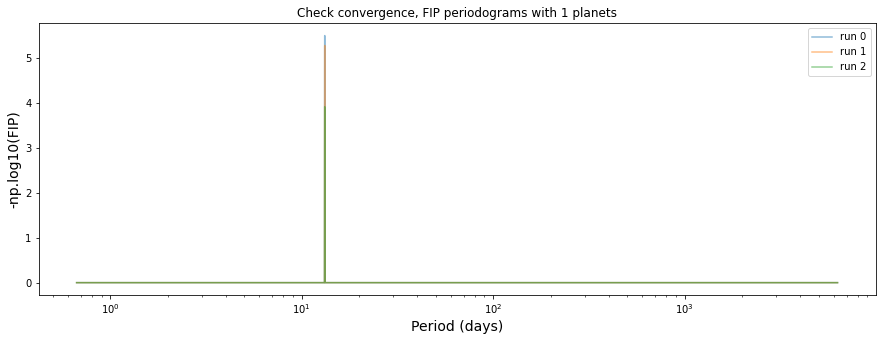

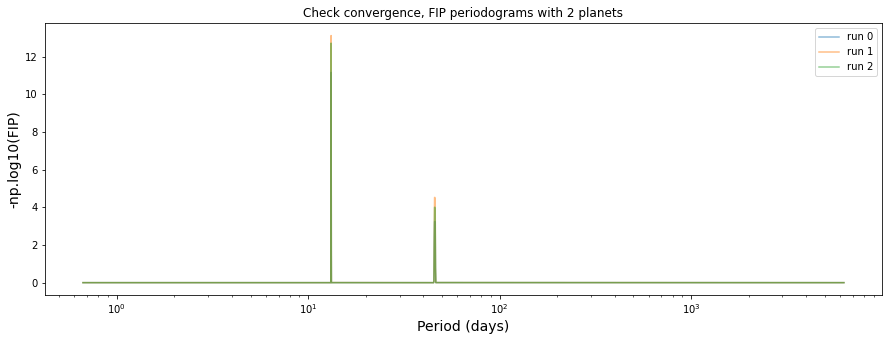

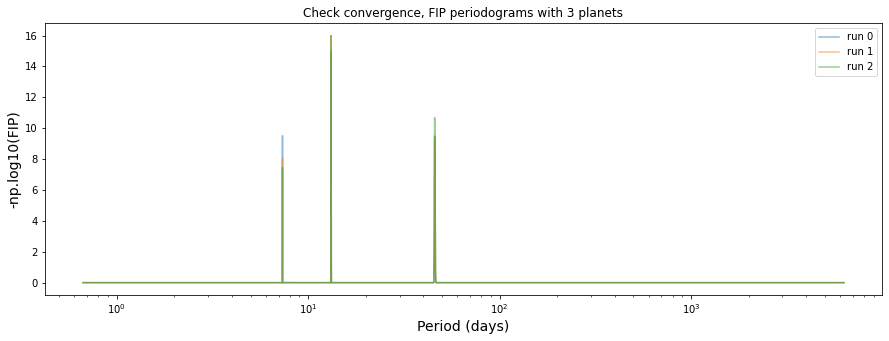

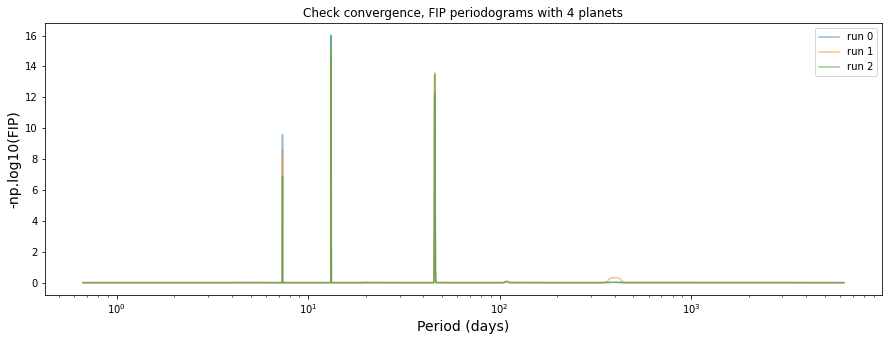

In [8]:
for i in range(1, n_max_planet + 1):
    key = 'k' + str(i)
    plt.figure(figsize=(15,5))
    plt.title('Check convergence, FIP periodograms with {} planets'.format(i))
    for j in range(n_runs):
        
        ind_fip_neg = fip_periodogram[key][str(j)]<= 0
        ind_fip_gt1 = fip_periodogram[key][str(j)]> 1
        
        fip_periodogram[key][str(j)][ind_fip_neg]  = 1e-16
        fip_periodogram[key][str(j)][ind_fip_gt1]  = 1-1e-16
        
        plt.semilogx(2*np.pi/omegas, -np.log10(fip_periodogram[key][str(j)]), label='run {}'.format(j), alpha=0.5)
    plt.legend()
    plt.xlabel('Period (days)', fontsize=14)
    plt.ylabel('-np.log10(FIP)', fontsize=14)


From one run to the other the FIP periodogram does not drastically change, and we can trust 

We now compute the FIP periodogram based on the median of the different runs. First, we need to compute the probability that there are $k$ planets, $p(k\mid y)$.

In [9]:
median_log_evidence_centered = median_log_evidence - np.mean(median_log_evidence)
median_evidence_centered = np.exp(median_log_evidence_centered)

# To compute the posterior probability to have k planets,
# we here assume that the k planet models are all equiprobable (they have the same prior probability)
posterior_k_planets = median_evidence_centered / np.sum(median_evidence_centered)

In [10]:
for k in range(n_max_planet+1):
    print('The posterior probability to have {} planets is'.format(k), posterior_k_planets[k]) 

The posterior probability to have 0 planets is 1.6628280774809642e-27
The posterior probability to have 1 planets is 7.496230397707749e-19
The posterior probability to have 2 planets is 4.559592607056141e-09
The posterior probability to have 3 planets is 0.6314846439465839
The posterior probability to have 4 planets is 0.3685153514938235


We can now see how the FIP periodogram evolves by increasing the maximum number of planets

There are only 1 peaks
Saving  _FIP_periodogram_notext.pdf
There are only 2 peaks
Saving  HD_93385_FIP_periodogram_notext.pdf
There are only 3 peaks
Saving  HD_93385_FIP_periodogram_notext.pdf
Saving  HD_93385_FIP_periodogram_notext.pdf


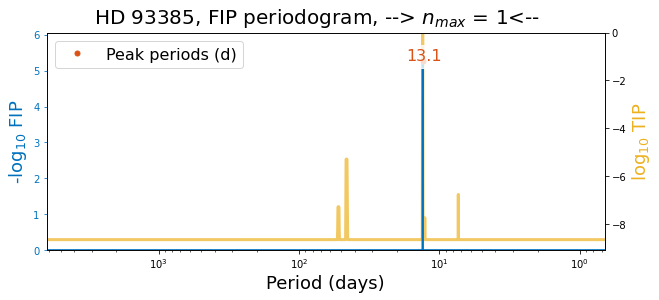

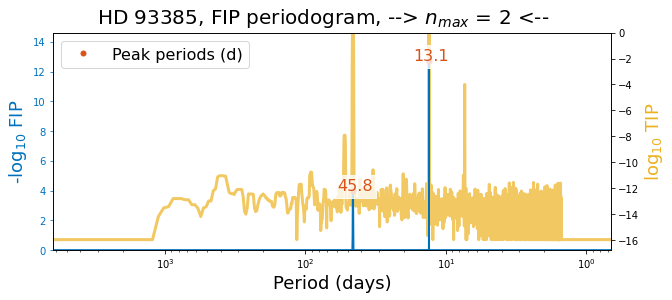

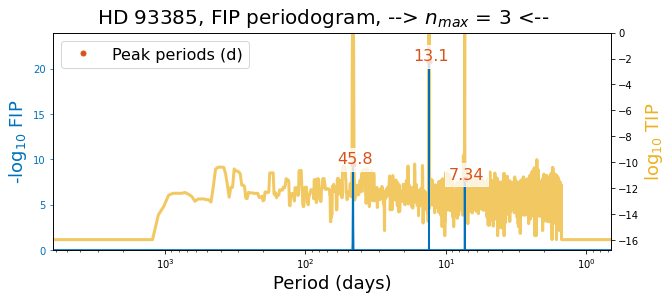

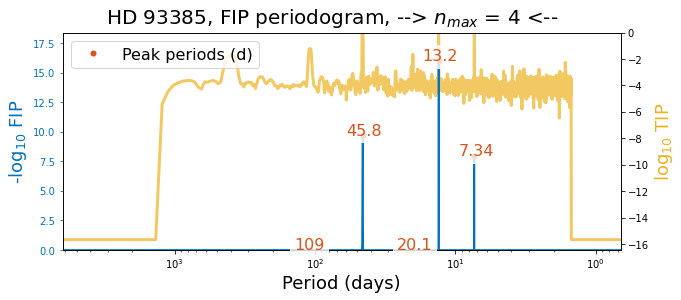

In [11]:
import fip_plots
normalization = np.sum(posterior_k_planets[:2])
fip_perio_max_k_planet = median_fip_perio[0,:]*posterior_k_planets[1]/normalization

c = fip_plots.fip_plots(freq_radday = omegas, fips = fip_perio_max_k_planet)
c.plot_clean(number_highlighted_peaks_in=4,
         title=r'HD 93385, FIP periodogram, --> $n_{max}$ = '+str(1)+ '<--', save=True)

for k in range(1,n_max_planet):
    fip_perio_max_k_minus_1_planets = fip_perio_max_k_planet*normalization
    
    normalization = np.sum(posterior_k_planets[:k+2])
    fip_perio_max_k_planet = (fip_perio_max_k_minus_1_planets + median_fip_perio[k, :]*posterior_k_planets[k+1])/normalization
    # in the renormalization a negative value might have snuck in
    fip_perio_max_k_planet[fip_perio_max_k_planet <=0] = 1e-16
    # or a value above 1
    fip_perio_max_k_planet[fip_perio_max_k_planet >=1] = 1-1e-16
    
    c = fip_plots.fip_plots(freq_radday = omegas, fips = fip_perio_max_k_planet)
    c.plot_clean(number_highlighted_peaks_in=5, starname = 'HD 93385',
            title=r'HD 93385, FIP periodogram, --> $n_{max}$ = '+str(k+1)+ ' <--', save=True)
    


We see that when increasing the maximum number of planets from 3 to 4, meaning that there is no need to compute the evidence for a five planets model, and there are hints at 109 and 20.1 days. 

Note that we plot both -log10(FIP) and log10(TIP), which contains the same information since FIP = 1 - TIP. The quantity -log10(FIP) discriminates between signals which are significant and very significant, and the TIP shows interesting candidates.

Saving  HD_93385_FIP_periodogram_notext.pdf


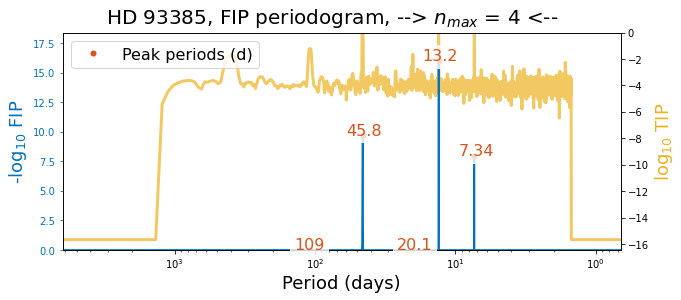

In [12]:
c.plot_clean(number_highlighted_peaks_in=5, starname = 'HD 93385',
        title=r'HD 93385, FIP periodogram, --> $n_{max}$ = '+str(k+1)+ ' <--', save=True)
